<a href="https://colab.research.google.com/github/ibacaraujo/fastai-deep-learning-from-the-foundations/blob/master/lesson8_deeplearning_from_the_foundations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 8: Matrix multiplication; forward and backward passes

In [0]:
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

## Get data

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [4]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
  ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [6]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor([5, 0, 4,  ..., 8, 4, 8]),
 torch.Size([50000]),
 tensor(0),
 tensor(9))

In [0]:
assert n == y_train.shape[0] == 50000
test_eq(c, 28*28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

In [0]:
img = x_train[0]

In [10]:
img.view(28,28).type()

'torch.FloatTensor'

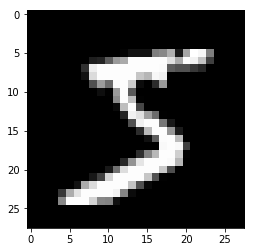

In [11]:
plt.imshow(img.view(28, 28));

## Initial Python model

In [0]:
weights = torch.randn(784, 10)

In [0]:
bias = torch.zeros(10)

In [0]:
# Matrix multiplication
def matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    for j in range(b_ncols):
      for k in range(a_ncols):
        c[i, j] += a[i,k] * b[k,j]
  return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [16]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [17]:
%time t1 = matmul(m1, m2)

CPU times: user 906 ms, sys: 1.1 ms, total: 907 ms
Wall time: 909 ms


In [18]:
t1.shape

torch.Size([5, 10])

Kinda slow. Could we speed it up by 50,000 times? Let's try.

In [19]:
len(x_train)

50000

**Elementwise operations**

In [20]:
a = tensor([10., 6, -4])
b = tensor([2., 8, 7])
a,b

(tensor([10.,  6., -4.]), tensor([2., 8., 7.]))

In [21]:
a + b

tensor([12., 14.,  3.])

In [22]:
(a < b).float().mean()

tensor(0.6667)

In [23]:
m = tensor([[1., 2, 3], [4, 5, 6], [7, 8, 9]]); m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [24]:
# Frobenius norm
(m*m).sum().sqrt()

tensor(16.8819)

**Elementwise matmul**

In [0]:
def matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    for j in range(b_ncols):
      # Any trailing ",;" can be removed
      c[i,j] = (a[i,:] * b[:,j]).sum()
  return c

In [29]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 1.67 ms per loop


In [0]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [0]:
test_near(t1, matmul(m1, m2))

## Broadcasting

The smaller array is "broadcast" across the larger array so that they have compatible shapes.

**Broadcasting with a scalar**

In [33]:
a

tensor([10.,  6., -4.])

In [34]:
a > 0

tensor([1, 1, 0], dtype=torch.uint8)

How are we able to do a > 0? 0 is being broadcast to have the same dimensions as a.

In [35]:
a + 1

tensor([11.,  7., -3.])

In [36]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [37]:
2 * m

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

**Broadcasting a vector to a matrix**

In [41]:
c = tensor([10., 20, 30]); c, c.shape

(tensor([10., 20., 30.]), torch.Size([3]))

In [40]:
m, m.shape

(tensor([[1., 2., 3.],
         [4., 5., 6.],
         [7., 8., 9.]]), torch.Size([3, 3]))

In [42]:
m + c

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [43]:
c + m

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

We don't really copy the row, but it looks as if we did.

In [0]:
t = c.expand_as(m)

In [45]:
t

tensor([[10., 20., 30.],
        [10., 20., 30.],
        [10., 20., 30.]])

In [46]:
m + t

tensor([[11., 22., 33.],
        [14., 25., 36.],
        [17., 28., 39.]])

In [47]:
t.storage()

 10.0
 20.0
 30.0
[torch.FloatStorage of size 3]

In [48]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

You can index with the special value [None] or use unsqueeze() to convert a 1-dimensional array into a 2-dimensional array (although one of those dimensions has value 1).

In [56]:
c.unsqueeze(0),  c.unsqueeze(0).shape

(tensor([[10., 20., 30.]]), torch.Size([1, 3]))

In [53]:
c.unsqueeze(1), c.unsqueeze(1).shape

(tensor([[10.],
         [20.],
         [30.]]), torch.Size([3, 1]))

In [54]:
m

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [55]:
c.shape, c.unsqueeze(0).shape, c.unsqueeze(1).shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

In [57]:
c.shape, c[None].shape, c[:, None].shape

(torch.Size([3]), torch.Size([1, 3]), torch.Size([3, 1]))

You can always skip trailling ':'s. And '...' means 'all preceding dimensions'

In [58]:
c[None].shape, c[..., None].shape

(torch.Size([1, 3]), torch.Size([3, 1]))

In [59]:
c[:, None].expand_as(m)

tensor([[10., 10., 10.],
        [20., 20., 20.],
        [30., 30., 30.]])

In [61]:
m + c[:,None]

tensor([[11., 12., 13.],
        [24., 25., 26.],
        [37., 38., 39.]])

In [62]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

**Matmul with broadcasting**

In [0]:
def matmul(a, b):
  a_nrows, a_ncols = a.shape
  b_nrows, b_ncols = b.shape
  assert a_ncols == b_nrows
  c = torch.zeros(a_nrows, b_ncols)
  for i in range(a_nrows):
    c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
  return c

In [69]:
%timeit -n 10 _=matmul(m1, m2)

10 loops, best of 3: 301 µs per loop


In [0]:
test_near(t1, matmul(m1, m2))

**Broadcasting Rules**

In [71]:
c[None,:]

tensor([[10., 20., 30.]])

In [72]:
c[None,:].shape

torch.Size([1, 3])

In [73]:
c[:,None]

tensor([[10.],
        [20.],
        [30.]])

In [74]:
c[:,None].shape

torch.Size([3, 1])

In [76]:
c[None,:] * c[:,None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

In [77]:
c[None] > c[:,None]

tensor([[0, 1, 1],
        [0, 0, 1],
        [0, 0, 0]], dtype=torch.uint8)

## Einstein summation

In [0]:
def matmul(a, b):
  return torch.einsum('ik,kj->ij', a, b)

In [79]:
%timeit -n 10 _=matmul(m1, m2)

The slowest run took 66.62 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 48.4 µs per loop


In [0]:
test_near(t1, matmul(m1, m2))

## PyTorch op

In [83]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 62.00 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 8.46 µs per loop


In [84]:
%timeit t2 = m1@m2

The slowest run took 20.89 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.24 µs per loop
